In [2]:
# --- 1. Imports ---
from ultralytics import YOLO
from paddleocr import PaddleOCR
import re
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import easyocr
import numpy as np

# --- 2. Cargar modelo YOLO ---
ids_model = YOLO("/home/gnz/GitHub/yolo11_container/YOLO_IDs/ID_YOLO_container/weights/best.pt")

char_model = YOLO("/home/gnz/GitHub/yolo11_container/YOLO_Characters/Character_YOLO_container/weights/best.pt")

# --- 3. Inicializar EasyOCR ---
easy_ocr_model = easyocr.Reader(['en','es'])  # podés agregar ['en', 'es'] si querés español
# PaddleOCR inicializado (puedes ajustar lang si necesitas chino, inglés, etc.)
paddle_ocr_model = PaddleOCR(use_textline_orientation=True, lang="en")


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
/home/gnz/GitHub/yolo11_container/.venv/lib/python3.12/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/gnz/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/gnz/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/gnz

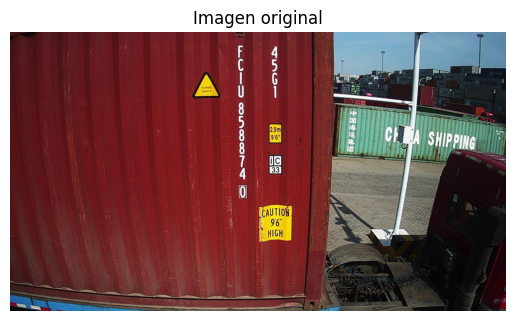

In [3]:
# --- 4. Cargar imagen de prueba ---
image_path_cn11 = "/home/gnz/GitHub/yolo11_container/images/1-132606001-OCR-RF-D01_jpg.rf.f35e386792d0ca3486542a283ecfb327.jpg"
image = cv2.imread(image_path_cn11)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convertir a RGB
plt.imshow(image)
plt.title("Imagen original")
plt.axis("off")
plt.show()


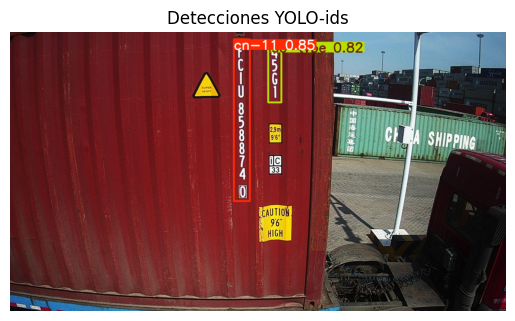

In [4]:
# --- 5. Inferencia con YOLO-ids ---
results_ids = ids_model.predict(image, conf=0.25, verbose=False)
annotated = results_ids[0].plot()  # imagen con bounding boxes dibujados

plt.imshow(annotated)
plt.title("Detecciones YOLO-ids")
plt.axis("off")
plt.show()

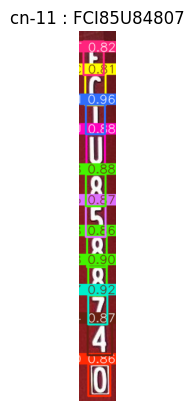

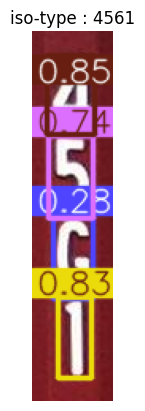

{'cn-11': 'FCI85U84807', 'iso-type': '4561'}


In [5]:
detecciones = {}  # aquí guardaremos "clase del primer modelo" : "string del segundo modelo"

# --- Loop sobre detecciones del primer modelo ---
for i, box in enumerate(results_ids[0].boxes):
    # Coordenadas del bounding box del primer modelo
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    crop = image[y1:y2, x1:x2]

    # Obtener clase del primer modelo
    cls_id = int(box.cls[0].item())
    cls_name = results_ids[0].names[cls_id]  # p.ej. "iso-type"

    # Inferencia con YOLO-characters en el crop
    results_char = char_model.predict(crop, conf=0.25, verbose=False)

    # Extraer nombres de las clases del segundo modelo (caracteres detectados)
    chars = []
    for char_box in results_char[0].boxes:
        char_id = int(char_box.cls[0].item())
        char_name = results_char[0].names[char_id]
        chars.append(char_name)

    # Concatenar caracteres en un string (ordenar por X si quieres respetar el orden visual)
    # Ordenar por coordenada X del bounding box
    boxes_with_chars = sorted(
        zip(results_char[0].boxes.xyxy.tolist(), chars),
        key=lambda b: b[0][0]  # ordenar por x1
    )
    string_detectado = "".join([c for _, c in boxes_with_chars])

    # Guardar en el diccionario
    detecciones[cls_name] = string_detectado

    # Mostrar el crop anotado
    annotated_char = results_char[0].plot()
    plt.imshow(annotated_char)
    plt.title(f"{cls_name} : {string_detectado}")
    plt.axis("off")
    plt.show()

print(detecciones)


Crop 1 → FCIU8588740


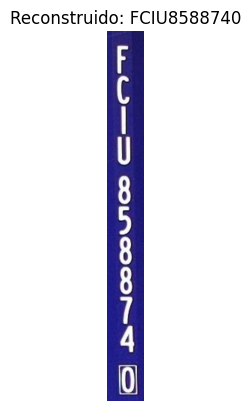

Crop 2 → 4561


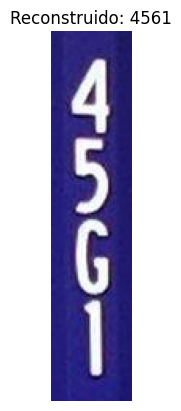

In [10]:
# --- 2. Recorrer los crops detectados en el primer modelo ---
ordered_codes = []

for i, box in enumerate(results_ids[0].boxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    crop = image[y1:y2, x1:x2]

    # Verificamos si el crop parece "vertical"
    h, w = crop.shape[:2]
    is_vertical = h > w   # heurística simple, la podés ajustar
    
    if is_vertical or box.cls in ["cn-4", "cn-11"]:
        # --- 3. Pasar el crop por el modelo de caracteres ---
        char_results = char_model(crop)

        chars = []
        for cbox in char_results[0].boxes:
            cx1, cy1, cx2, cy2 = map(int, cbox.xyxy[0].tolist())
            char_crop = crop[cy1:cy2, cx1:cx2]

            # (Opcional) aplicar OCR a cada caracter
            # Por simplicidad, si entrenás YOLO para clasificar dígito/letra,
            # podrías extraer directamente cbox.cls → que sería el caracter.
            char_label = char_model.names[int(cbox.cls)]
            chars.append((cy1, char_label))  # usamos cy1 para ordenar

        # --- 4. Ordenar caracteres por posición vertical (top to bottom) ---
        chars = sorted(chars, key=lambda x: x[0])

        # --- 5. Concatenar en un string ---
        code = "".join([c[1] for c in chars])
        ordered_codes.append(code)

        # Visualización rápida
        print(f"Crop {i+1} → {code}")
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Reconstruido: {code}")
        plt.axis("off")
        plt.show()

    else:
        # Si es horizontal → mandar directo a OCR normal
        ordered_codes.append("OCR_Horizontal")
